## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [3]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

# Функция для подсчета числа параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cuda


In [5]:
class Baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(Baseline, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Полносвязные слои
        self.fc1 = nn.Linear(in_features=32 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        # Прямой проход через сверточные слои
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)

        # Вытягивание в одномерный вектор
        x = x.view(x.size(0), -1)

        # Прямой проход через полносвязные слои
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

100%|██████████| 170M/170M [00:04<00:00, 41.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


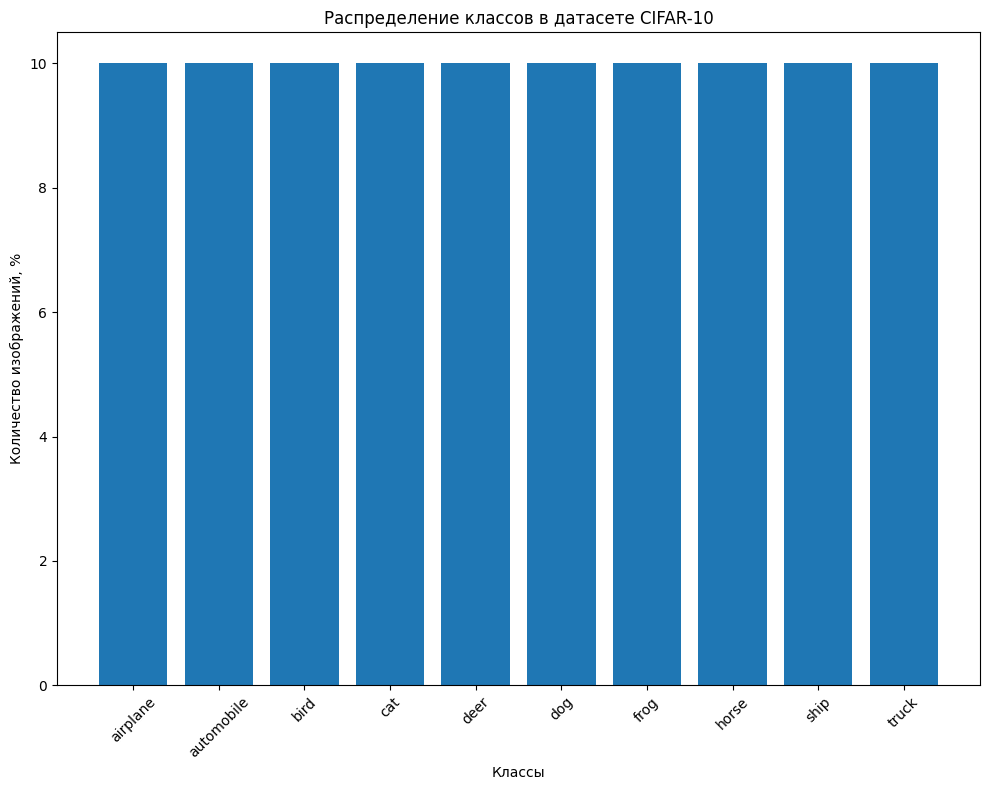

In [6]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()

# Загрузим датасеты для train и test
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))

# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100

# Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts) # указываем метки классов и значения
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

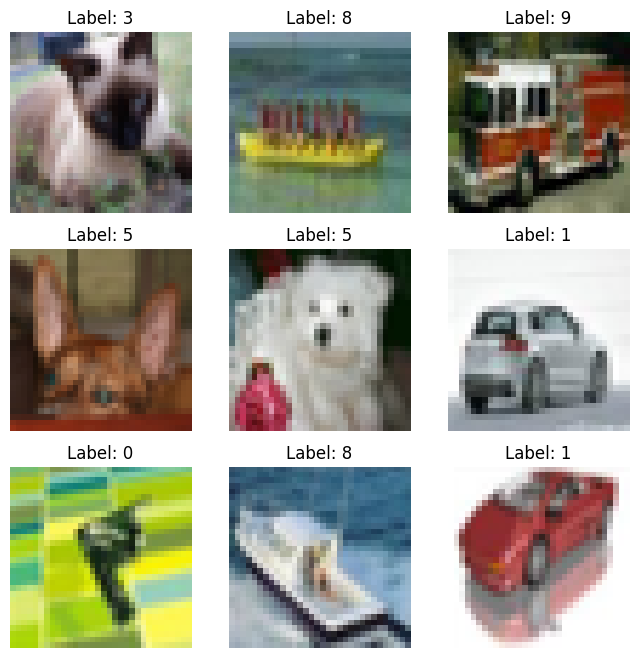

In [7]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

# Создайте сетку 3x3 для отображения изображений
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))  # Перевести изображение из формата (C, H, W) в (H, W, C)
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?

Напишем функции train и test

In [8]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.train()
    model = model.to(device) # перевод молели на устройство (cuba)
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, desc='Train epoch {}/{}'.format(epoch + 1, epochs))
        for batch_idx, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            # Занулите градиенты оптимизатора
            optimizer.zero_grad()
            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs, labels) #Вычисление функции потерь

            # Сделайте обратный проход
            loss.backward()
            # Сделайте шаг оптимизации
            optimizer.step()

            running_loss += loss.item()

            # Вычислите точность предсказания
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) # Обновление общего числа элементов
            correct += (predicted == labels).sum().item() # Обновление числа правильных предсказаний
            pbar.set_postfix({'loss': '{:.4f}'.format(running_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})

        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct / total)
        correct = 0
        total = 0
        test_loss = 0.0
        pbar = tqdm(enumerate(val_loader), total=len(val_loader), ncols=100, desc='Val {}/{}'.format(epoch + 1, epochs))
        with torch.no_grad():
            for batch_idx, (inputs, labels) in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs) # Прямой проход через модель валидации
                loss = criterion(outputs, labels) # Вычисление функции потерь для валидации
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0) # Обновление общего числа элементов
                correct += (predicted == labels).sum().item() # Обновление числа правильных предсказаний
                pbar.set_postfix({'loss': '{:.4f}'.format(test_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})
        val_loss_history.append(test_loss / len(val_loader))
        val_acc_history.append(correct / total)

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) # Прямой проход через модель
            loss = criterion(outputs, labels) #Вычисление функции потерь
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) # Обновление общего числа элементов
            correct += (predicted == labels).sum().item() # Обновление числа правильных предсказаний

    accuracy = correct / total
    average_loss = test_loss / len(test_loader)

    return accuracy, average_loss

Сделайте разделение на train и val
\
Зачем так делать?

In [9]:
train_size = int(0.8 * len(train_dataset))  # 80% для обучения
val_size = len(train_dataset) - train_size  # 20% для валидации

train_dataset, val_dataset = train_test_split(train_dataset, test_size=val_size / len(train_dataset), random_state=42, shuffle=True)

Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

In [10]:
# Гиперпараметры
learning_rate = 0.001  # Скорость обучения
num_epochs = 10        # Количество эпох
batch_size = 64        # Размер батча

# Создаем модель
model = Baseline()  # Используем вашу модель Baseline

print('Model params: ', count_parameters(model))

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()  # Функция потерь для задачи классификации
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Оптимизатор Adam

# Загрузчики данных
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model params:  268650


Обучите модель и постройте графики обучения

In [11]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=num_epochs)

Val 10/10: 100%|███████████████████| 157/157 [00:00<00:00, 256.01it/s, loss=0.9823, accuracy=0.6613]


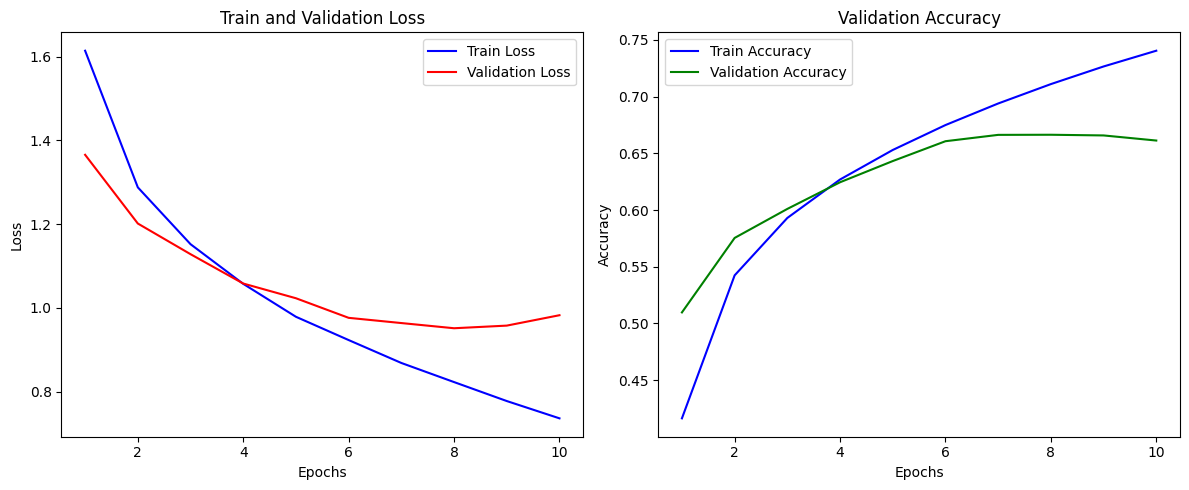

In [12]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Сделайте выводы о качестве обучения

Оцените тестовую метрику на тестовых данных

In [13]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.9902
Test Accuracy: 0.6610


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов

In [14]:
# Определяем трансформации для тренировочного набора данных
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение изображения
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация изображения с средним и стандартным отклонением по каналам
])

# Определяем трансформации для тестового набора данных
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация изображения с средним и стандартным отклонением по каналам
])

transform = transforms.ToTensor()


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)


test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
train_size = int(0.8 * len(train_dataset))  # 80% данных для обучения и 20% для валидации
val_size = len(train_dataset) - train_size

# Разделение на обучающий и валидационный датасеты
train_dataset, val_dataset = train_test_split(train_dataset, test_size=val_size, random_state=42, shuffle=True)

In [16]:
from torchvision.transforms import GaussianBlur

class AugmentationLayer(nn.Module):
    def __init__(self):
        super(AugmentationLayer, self).__init__()

    def forward(self, x):
        # С вероятностью 50% переворачиваем изображение по горизонтали
        if torch.rand(1) > 0.5:
            x = torch.flip(x, [3])

        import torchvision.transforms.functional as F
        # С вероятностью 50% применяем случайный сдвиг изображения
        if torch.rand(1) > 0.5:
            max_shift = 4  # Максимальное смещение в пикселях
            dx = torch.randint(low=-max_shift, high=max_shift + 1, size=(1,)).item()  # Случайное смещение по оси x
            dy = torch.randint(low=-max_shift, high=max_shift + 1, size=(1,)).item()  # Случайное смещение по оси y
            x = F.affine(x, angle=0, translate=(dx, dy), scale=1.0, shear=0)  # Применяем аффинное преобразование

        return x

In [17]:
class UpdatedModel(nn.Module):
    def __init__(self, num_classes=10):
        super(UpdatedModel, self).__init__()
        self.augmentation_layer = AugmentationLayer()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.4)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = self.augmentation_layer(x)
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [18]:
learning_rate = 0.003
num_epochs = 160
batch_size = 128

model = UpdatedModel()

print('Model params: ', count_parameters(model))

# Определяем функцию потерь и оптимизатор
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Создание загрузчиков данных для тренировки, валидации и тестирования
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model params:  4577290


In [19]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=num_epochs)

Val 160/160: 100%|███████████████████| 79/79 [00:00<00:00, 122.97it/s, loss=0.6503, accuracy=0.8424]


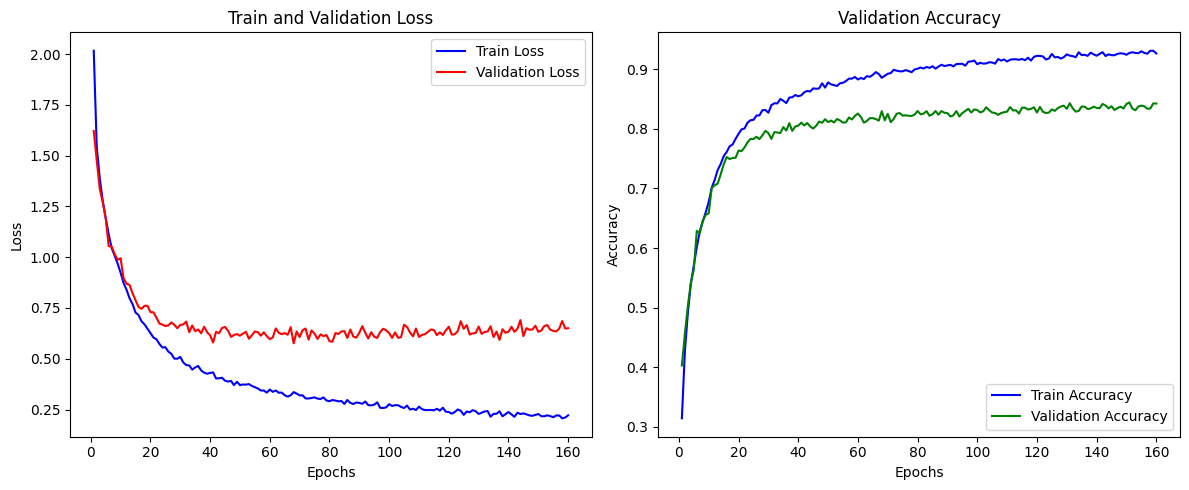

In [20]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.4696
Test Accuracy: 0.8704
